In [1]:
import warnings
warnings.filterwarnings("ignore")

from typing import Optional, List, Union
from numpy.typing import NDArray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from tsururu.strategies import StrategiesFactory
from tsururu.dataset import TSDataset
from tsururu.models import MeanMethod, NaiveMethod, SeasonalNaiveMethod, DriftMethod

In [2]:
def get_results(
    cv: int,
    regime: str,
    y_true: Optional[List[NDArray[np.floating]]] = None,
    y_pred: Optional[List[NDArray[np.floating]]] = None,
    ids: Optional[List[Union[float, str]]] = None,
) -> pd.DataFrame:
    def _get_fold_value(
        value: Optional[Union[float, NDArray[np.floating]]], idx: int
    ) -> List[Optional[Union[float, NDArray[np.floating]]]]:
        if value is None:
            return [None]
        if isinstance(value[idx], float):
            return value[idx]
        if isinstance(value[idx], np.ndarray):
            return value[idx].reshape(-1)
        raise TypeError(f"Unexpected value type. Value: {value}")

    df_res_dict = {}

    for idx_fold in range(cv):
        # Fill df_res_dict
        for name, value in [("y_true", y_true), ("y_pred", y_pred)]:
            df_res_dict[f"{name}_{idx_fold+1}"] = _get_fold_value(
                value, idx_fold
            )
        if regime != "local":
            df_res_dict[f"id_{idx_fold+1}"] = _get_fold_value(ids, idx_fold)

    # Save datasets to specified directory
    df_res = pd.DataFrame(df_res_dict)
    return df_res

def plot_baseline_results(df):
    unique_ids = sorted(df['id'].unique())
    num_ids = len(unique_ids)
    fig, axes = plt.subplots(num_ids, 1, figsize=(10, 20))

    for i, id_value in enumerate(unique_ids):
        data = df[df['id'] == id_value]
        
        axes[i].plot(data['date'], data['value'], label='y_true', color='royalblue')
        axes[i].plot(data['date'].tail(96), data['value'].tail(96), label='y_pred', color='maroon')

        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].set_title(f'TS id {id_value}')
        axes[i].grid(True)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_ml_results(df, res, axes):
    for i, ax in enumerate(axes):
        df_slice = res.iloc[i * 96: (i + 1) * 96] 
        x1 = np.linspace(200-96,200,96)
        x2 = np.linspace(0,200-96,200-96)
        ax.plot(df[df['id'] == i]['value'].tail(200).reset_index(drop=True), label='y_true', c ='royalblue')
        ax.plot(x1, df_slice['y_pred_1'], label='y_pred',c ='maroon') 
        mae = MAE(df[df['id'] == i]['value'].tail(96), df_slice['y_pred_1'])
        mse = MSE(df[df['id'] == i]['value'].tail(96), df_slice['y_pred_1'])
        ax.set_title(f'id {i}, MAE = {mae:.4f}, MSE = {mse:.4f}')
        ax.legend() 
        ax.grid(True)
    plt.tight_layout()

In [3]:
# for global and multivariate all time seires should be in one .csv file, divided by id 
# for local each time serie should be in its own .csv file also with id column 
df_path = "datasets/global/ettm1.csv"
df = pd.read_csv(df_path, sep=',')

# Configure the features settings
columns_and_features_params = {
    "target": {
        "column": ["value"],
        "type": "continious",
        "features": {
            "LagTransformer": {"lags": 30},
            "LastKnownNormalizer": {
                "regime": "ratio",
                "transform_train": False,
                "transform_target": False
            } 
        },
        "drop_raw_feature": False,
    },
    "date": {
        "column": ["date"],
        "type": "datetime",
        "features": {
            "DateSeasonsGenerator": {
                # Use seasonality features from the date column as features with datetime lags
                # Possible values: [
                #    "y": year, "m": month, "d": day, 
                #    "wd": weekday, "doy": dayofyear,
                #    "hour": hour, "min": minute, "sec": second, 
                #    "ms": microsecond,  "ns": nanosecond
                # ]
                "seasonalities": ['min'], 
                # Use date from target point to make datetime features
                "from_target_date": True,
            },
            "LagTransformer": {"lags": 7}
        },
        "drop_raw_feature": True,
    },
    "id": {
        "column": ["id"],
        "type": "categorical",
        "drop_raw_feature": False,
    }
}

# Configure the model parameters
model_params_catboost = {
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 500,
}

model_params_linreg = {
    "fit_intercept": True,
    "n_jobs": -1,
    "positive": False
}

model_params_regularization = {
    'alpha': [0.01, 0.1, 1.0, 10.0], # Add more alphas if needed
}

model_params_randforest = {
    'n_estimators': 1000,           # Add more if needed
    'criterion': 'squared_error', # ['squared_error', 'absolute_error']
    'max_depth': None,
    
}

# Configure the validation parameters
validation_params = {
    "type": 'KFold',
    "n_splits": 3,
}

# Configure the strategies parameters
strategy_params = {
    "is_multivariate": False, 
    # possible values: 
    # [
    #     'RecursiveStrategy', 
    #     'DirectStrategy', 
    #     'DirRecStrategy', 
    #     'MIMOStrategy', 
    #     'FlatWideMIMOStrategy', 
    # ]
    "strategy_name": "RecursiveStrategy",
    "strategy_params": {
        "horizon": 96,
    # possible values: 
    # [
    #     'CatBoostRegressor_CV', 
    #     'LinearRegression_CV', 
    #     'Lasso_CV', 
    #     'Ridge_CV', 
    #     'RandomForest_CV', 
    # ]   
        "model_name": "LinearRegression_CV",
        "model_params": model_params_linreg,
        "validation_params": validation_params,
        "k": 1,
    }
}

In [4]:
strategies_factory = StrategiesFactory()

In [5]:
dataset = TSDataset(
    data=pd.read_csv(df_path),
    columns_and_features_params=columns_and_features_params,
    history=200,
)

strategy = strategies_factory[strategy_params]

# Baseline models

In [6]:
# Dataframe with horizon=96
history_df = dataset.make_padded_test(96)

### 1. Mean method

Mean method entails predicting that all future values will be the same, specifically equal to the historical data's average.


$$\hat{y}_{T+h|T} = \bar{y} = (y_{1}+\dots+y_{T})/T$$

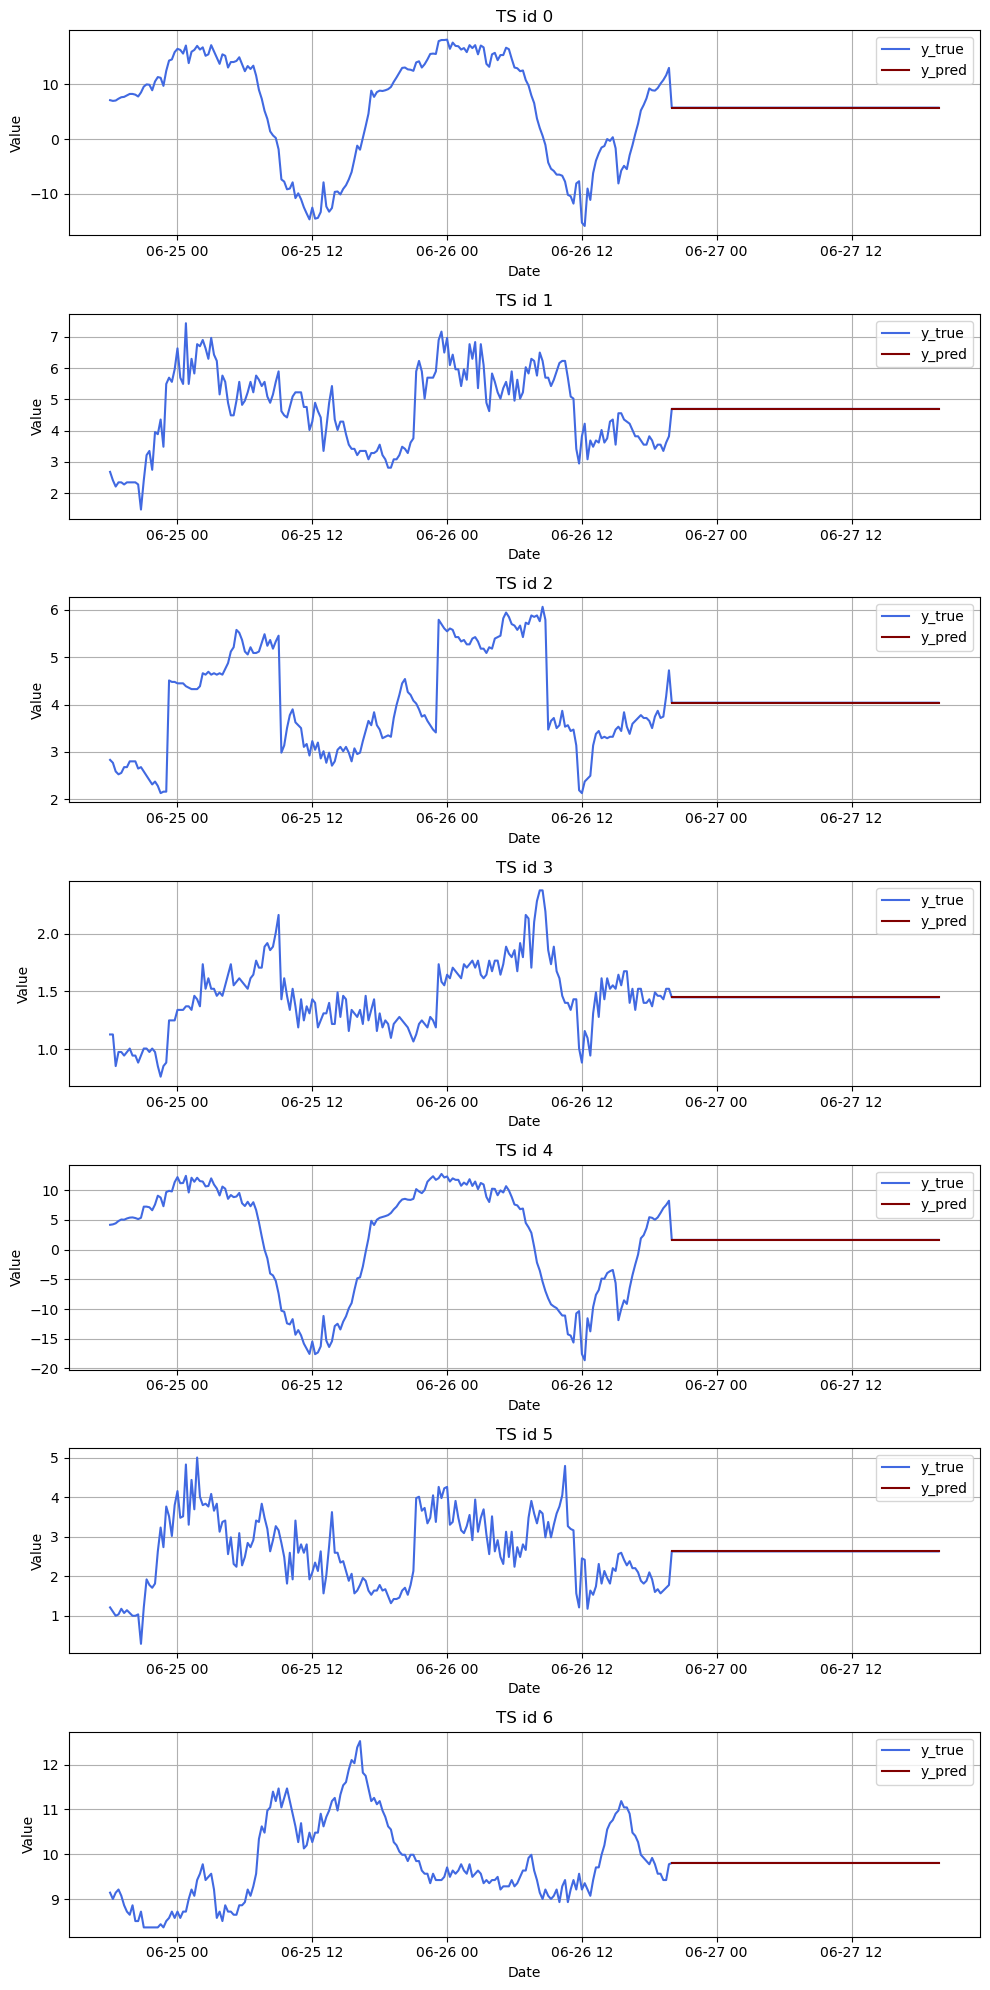

In [7]:
MM = MeanMethod(history_df)
preds_mm = MM.predict()

plot_baseline_results(preds_mm)

### 2. Naive method

Naive method entails predicting that all future values will be the same, specifically equal to the historical last kwown value.

$$\hat{y}_{T+h|T} = y_{T}$$

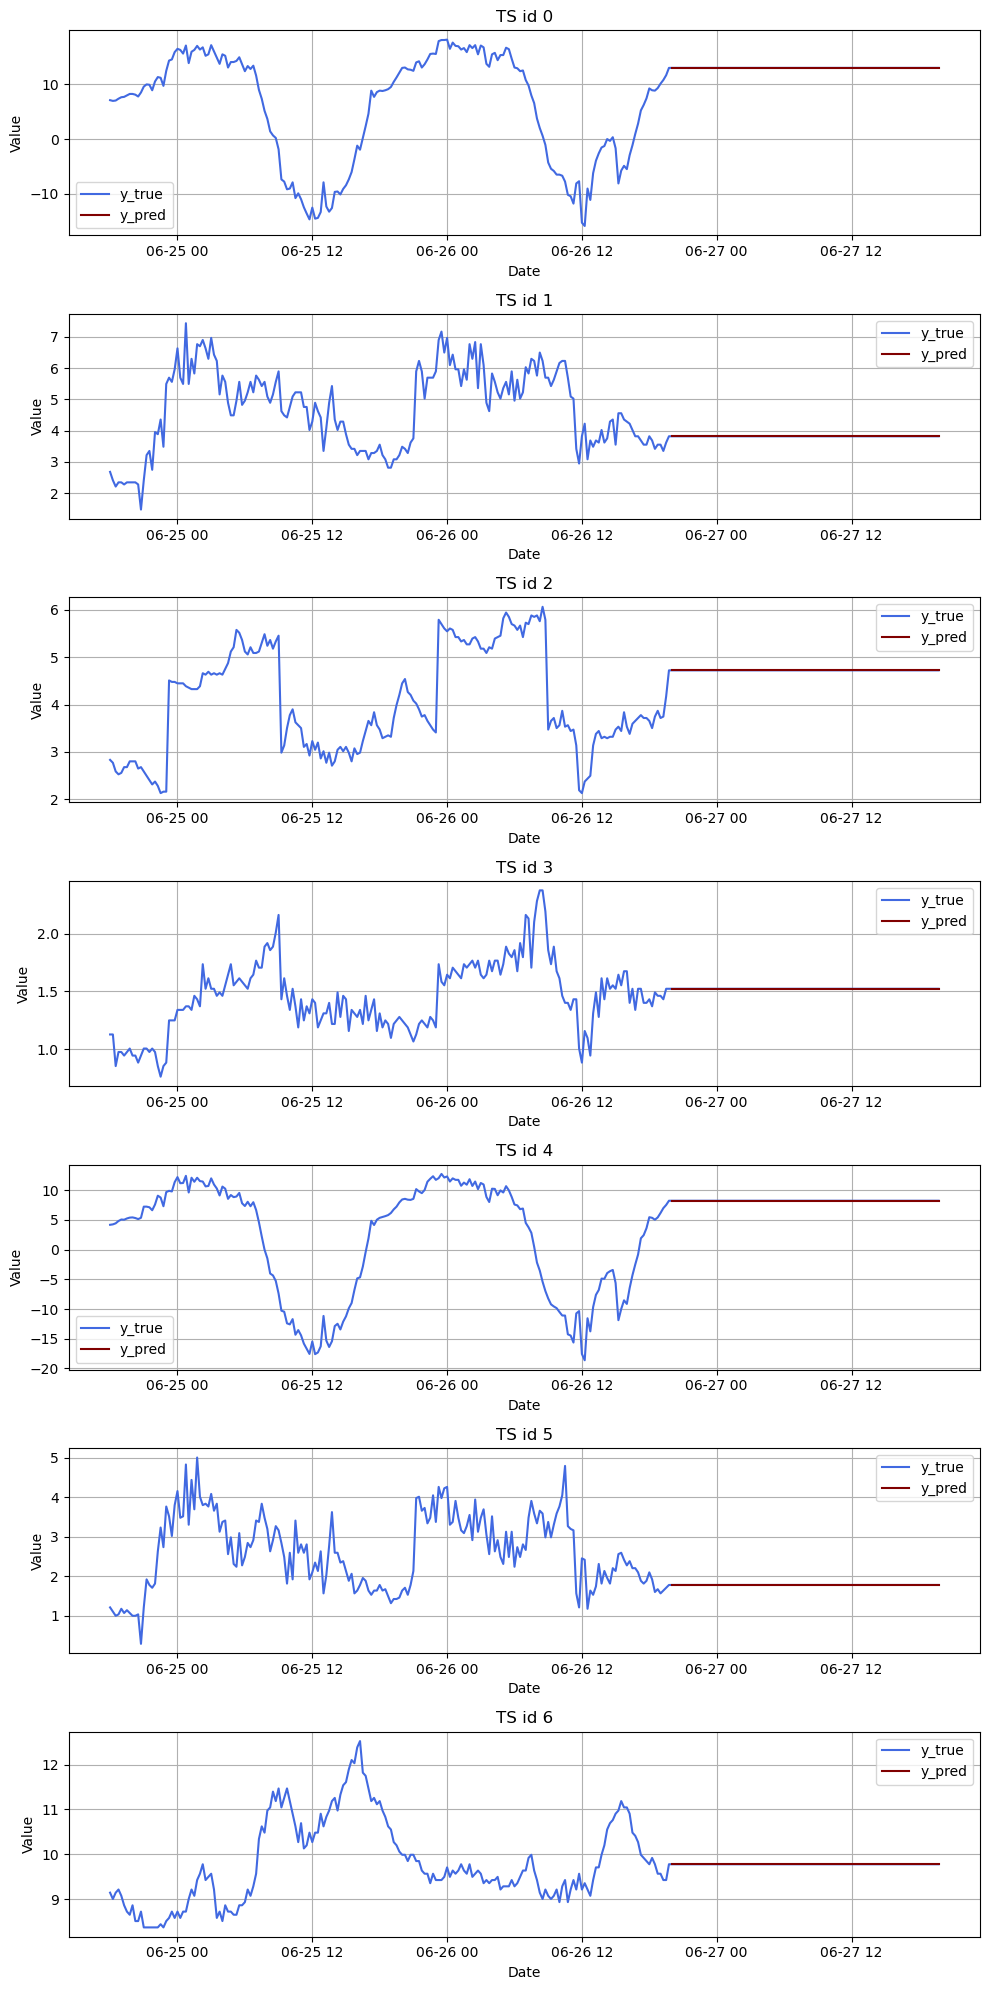

In [8]:
NM = NaiveMethod(history_df)
preds_nm = NM.predict()

plot_baseline_results(preds_nm)

### 3. Seasonal naive method

Predicts future values based on the values from the corresponding season in the previous cycle.

$$\hat{y}_{T+h|T} = y_{T+h-m(k+1)}$$

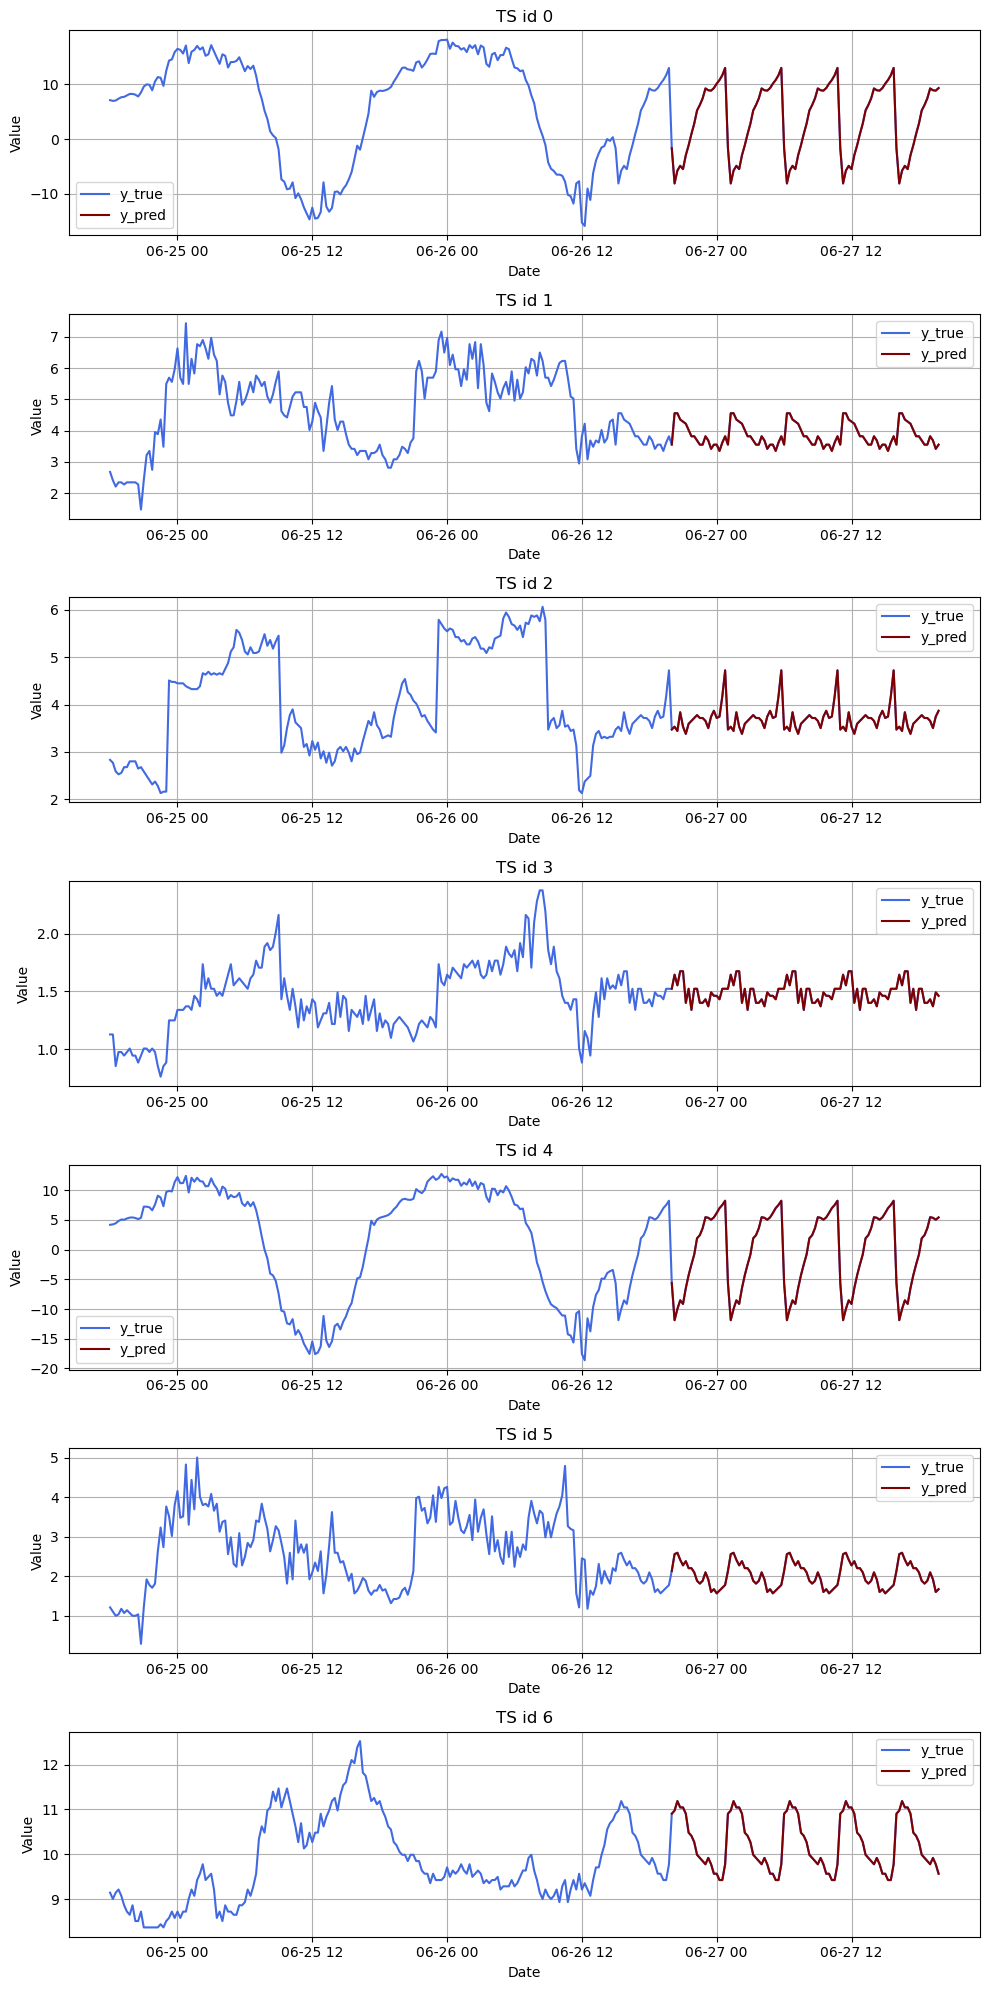

In [9]:
SNM = SeasonalNaiveMethod(history_df, 20) # where 20 points = season cycle
preds_snm = SNM.predict()

plot_baseline_results(preds_snm)

### 4. Drift method

A variation on the naive method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data.

$$\hat{y}_{T+h|T} = y_{T} + \frac{h}{T-1}\sum_{t=2}^T (y_{t}-y_{t-1}) = y_{T} + h \left( \frac{y_{T} -y_{1}}{T-1}\right)$$

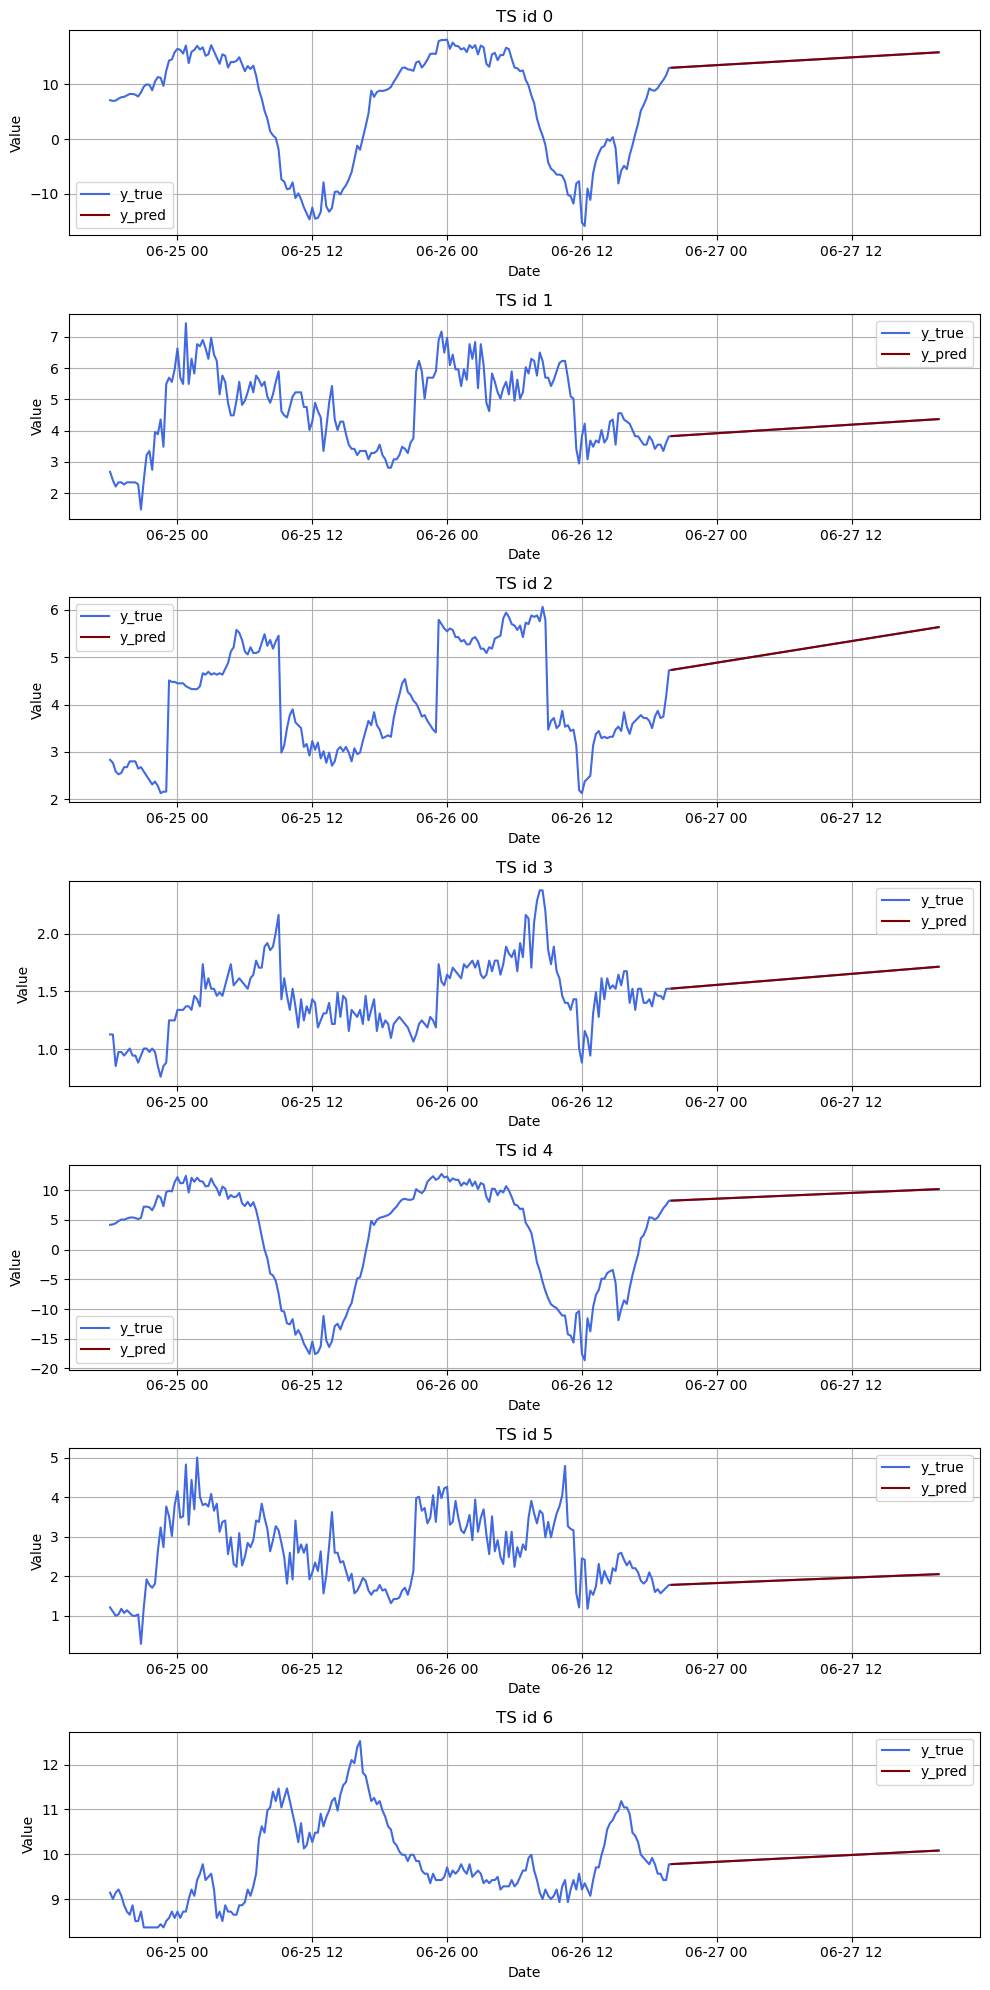

In [10]:
DRIFT = DriftMethod(history_df)
preds_drift = DRIFT.predict()

plot_baseline_results(preds_drift)

# ML models

### 1. Linear regression (from sklearn)

In [11]:
%%time
ids, test, pred, fit_time, forecast_time, num_iterations = strategy.back_test(dataset, cv=1)

Fold 1: Best Score: -0.46579471561020613
Fold 2: Best Score: -0.4646425226001617
Fold 3: Best Score: -0.4665564874869871
Mean score: -0.4656645752324516
Std: 0.0007867730657318689
CPU times: total: 3.86 s
Wall time: 8.86 s


In [12]:
vanilla_lr_preds = get_results(cv=1, regime="global", y_true=test, y_pred=pred, ids=ids)
vanilla_lr_preds.sample(10)

,y_true_1,y_pred_1,id_1
267,-3.411,4.658259,4
317,3.696,3.043437,5
164,3.483,3.435081,1
507,1.767,2.377752,3
670,9.426,7.416656,6
607,9.356,8.649773,6
368,2.274,4.231224,5
244,-8.209,4.585154,4
235,6.929,4.186757,4
408,5.269,4.304797,2


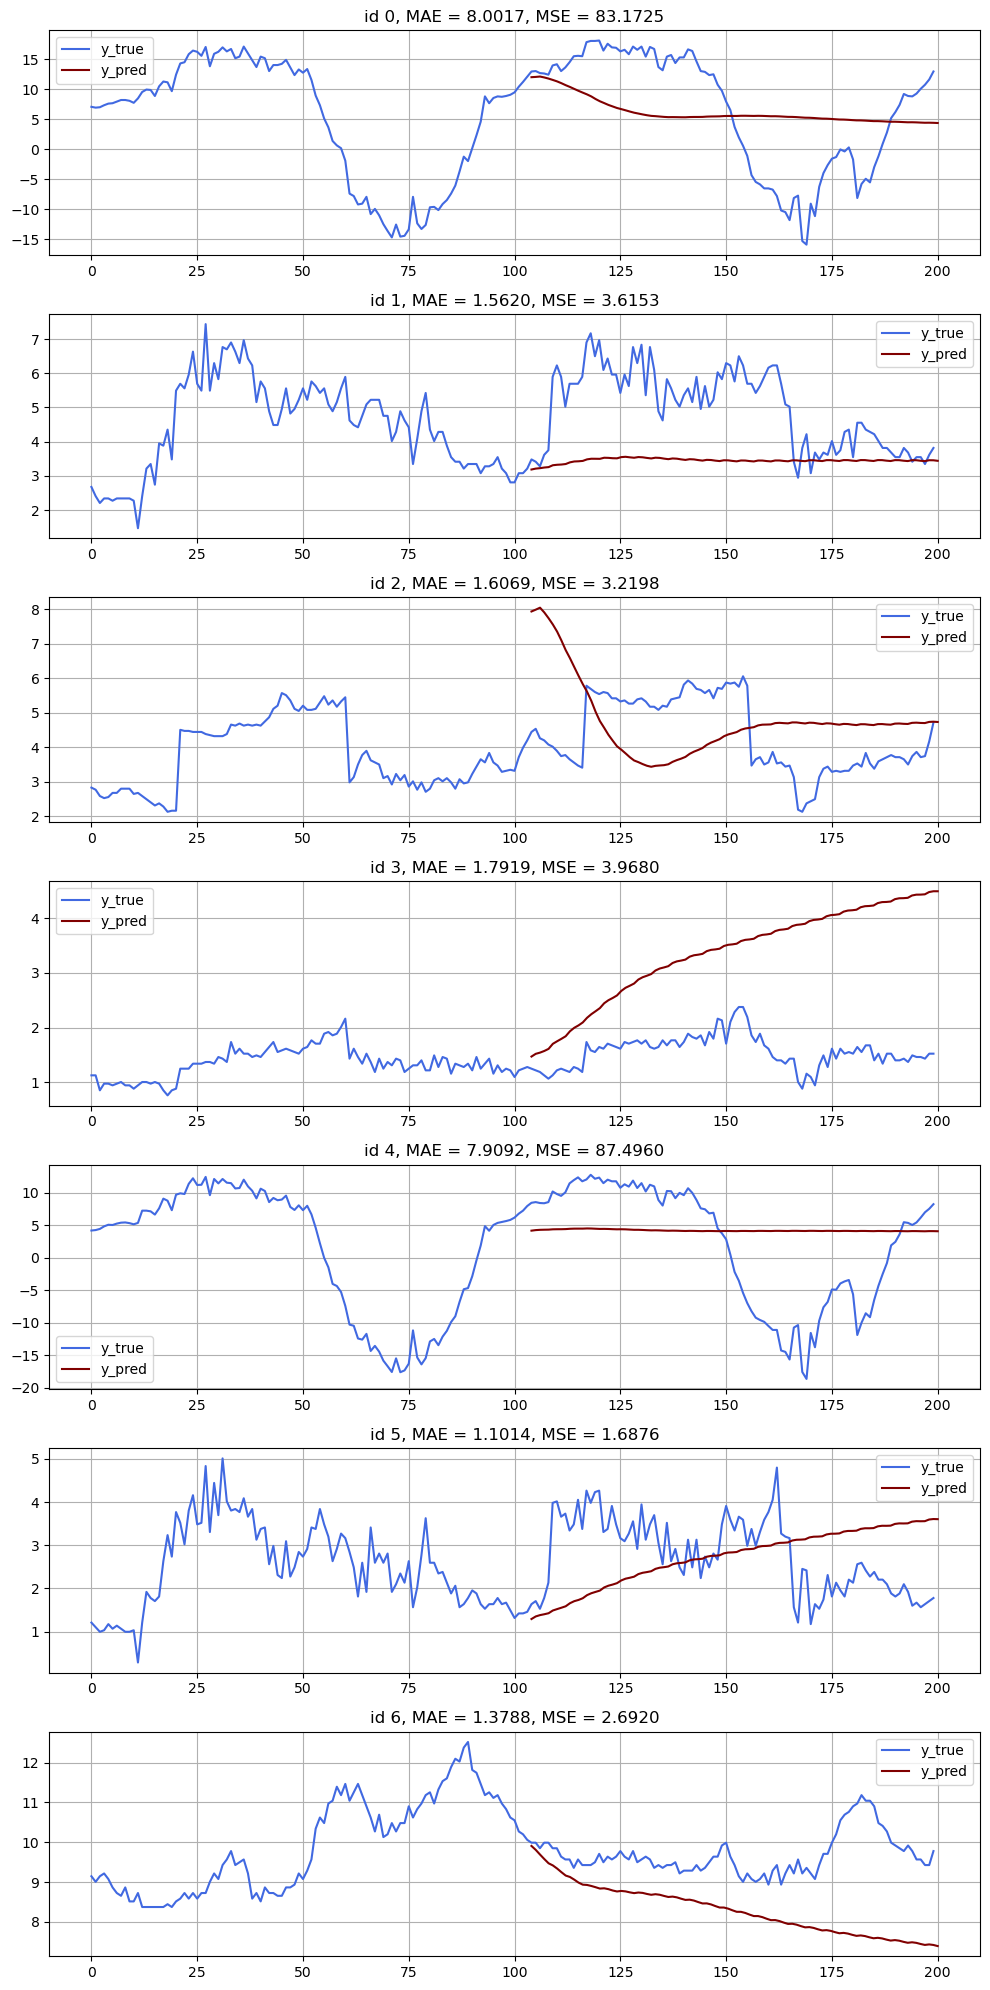

In [13]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_ml_results(df, vanilla_lr_preds, axes)

### 2. Lasso regression

In [14]:
strategy_params_lasso = {
    "is_multivariate": False, 
    # possible values: 
    # [
    #     'RecursiveStrategy', 
    #     'DirectStrategy', 
    #     'DirRecStrategy', 
    #     'MIMOStrategy', 
    #     'FlatWideMIMOStrategy', 
    # ]
    "strategy_name": "RecursiveStrategy",
    "strategy_params": {
        "horizon": 96,
    # possible values: 
    # [
    #     'CatBoostRegressor_CV', 
    #     'LinearRegression_CV', 
    #     'Lasso_CV', 
    #     'Ridge_CV', 
    #     'RandomForest_CV', 
    # ]   
        "model_name": "Lasso_CV",
        "model_params": model_params_regularization,
        "validation_params": validation_params,
        "k": 1,
    }
}

strategy_lasso = strategies_factory[strategy_params_lasso]

In [15]:
%%time
ids_lasso, test_lasso, pred_lasso, fit_time_lasso, forecast_time_lasso, num_iterations_lasso = strategy_lasso.back_test(dataset, cv=1)

Fold 1: Best Score: -0.5106474272189454
Fold 2: Best Score: -0.5112355066982379
Fold 3: Best Score: -0.5118806838338464
Mean score: -0.5112545392503433
Std: 0.000503654741583307
CPU times: total: 8.69 s
Wall time: 21.2 s


In [16]:
lasso_preds = get_results(cv=1, regime="global", y_true=test_lasso, y_pred=pred_lasso, ids=ids_lasso)
lasso_preds.sample(10)

,y_true_1,y_pred_1,id_1
428,5.726,4.471242,2
157,5.023,4.342283,1
505,1.767,2.988632,3
349,3.163,4.033153,5
62,-8.105,5.867216,0
507,1.767,3.075351,3
241,-3.518,5.400455,4
109,6.899,3.650567,1
297,3.340,2.223527,5
192,8.457,7.754418,4


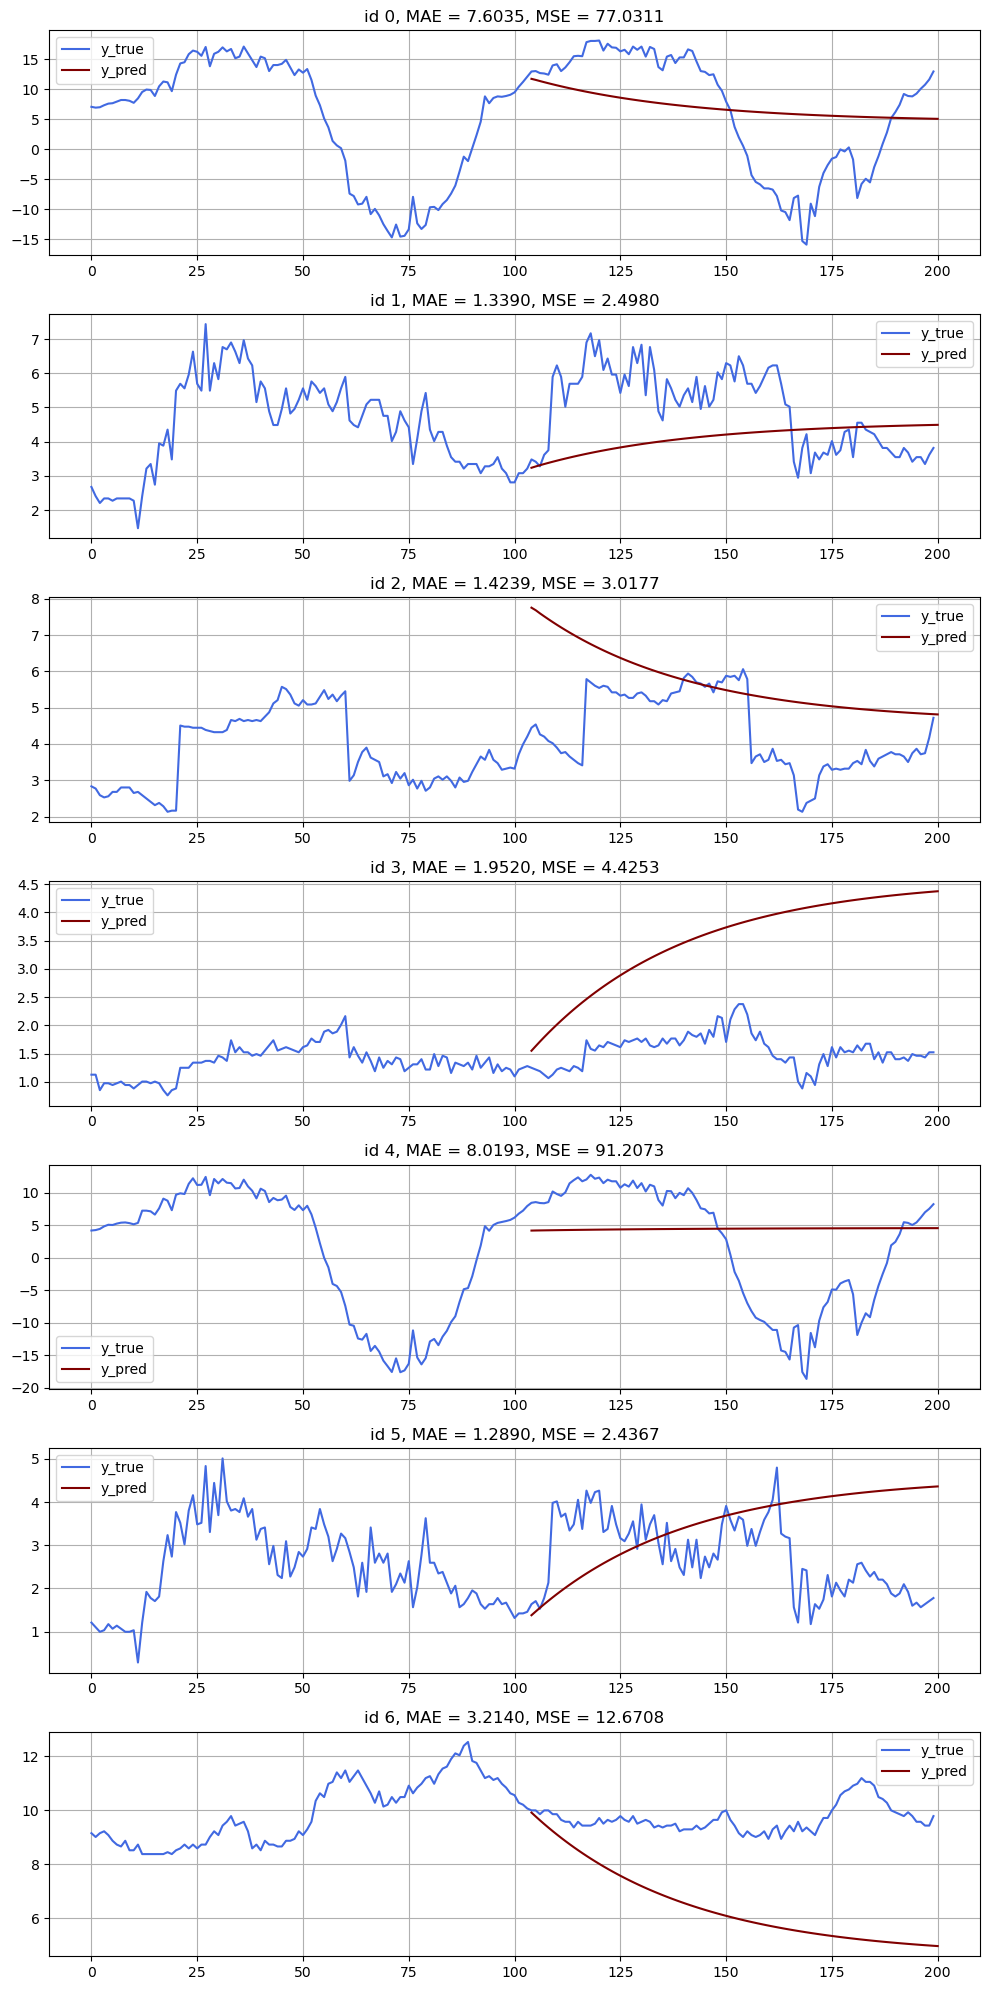

In [17]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_ml_results(df, lasso_preds, axes)

### 3. Ridge regression

In [18]:
strategy_params_ridge = {
    "is_multivariate": False, 
    # possible values: 
    # [
    #     'RecursiveStrategy', 
    #     'DirectStrategy', 
    #     'DirRecStrategy', 
    #     'MIMOStrategy', 
    #     'FlatWideMIMOStrategy', 
    # ]
    "strategy_name": "RecursiveStrategy",
    "strategy_params": {
        "horizon": 96,
    # possible values: 
    # [
    #     'CatBoostRegressor_CV', 
    #     'LinearRegression_CV', 
    #     'Lasso_CV', 
    #     'Ridge_CV', 
    #     'RandomForest_CV', 
    # ]   
        "model_name": "Ridge_CV",
        "model_params": model_params_regularization,
        "validation_params": validation_params,
        "k": 1,
    }
}

strategy_ridge = strategies_factory[strategy_params_ridge]

In [19]:
%%time
ids_ridge, test_ridge, pred_ridge, fit_time_ridge, forecast_time_ridge, num_iterations_ridge = strategy_ridge.back_test(dataset, cv=1)

Fold 1: Best Score: -0.46579740736626774
Fold 2: Best Score: -0.4646384167957497
Fold 3: Best Score: -0.46655630386632696
Mean score: -0.4656640426761148
Std: 0.0007886327025540518
CPU times: total: 2.3 s
Wall time: 6.46 s


In [20]:
ridge_preds = get_results(cv=1, regime="global", y_true=test_ridge, y_pred=pred_ridge, ids=ids_ridge)
ridge_preds.sample(10)

,y_true_1,y_pred_1,id_1
370,2.203,4.293158,5
25,16.611,5.981003,0
655,11.044,7.609582,6
527,2.102,2.834288,3
625,9.145,8.249333,6
469,3.777,4.114042,2
335,3.589,3.520665,5
23,15.874,6.316584,0
593,9.497,8.841768,6
407,5.269,4.339539,2


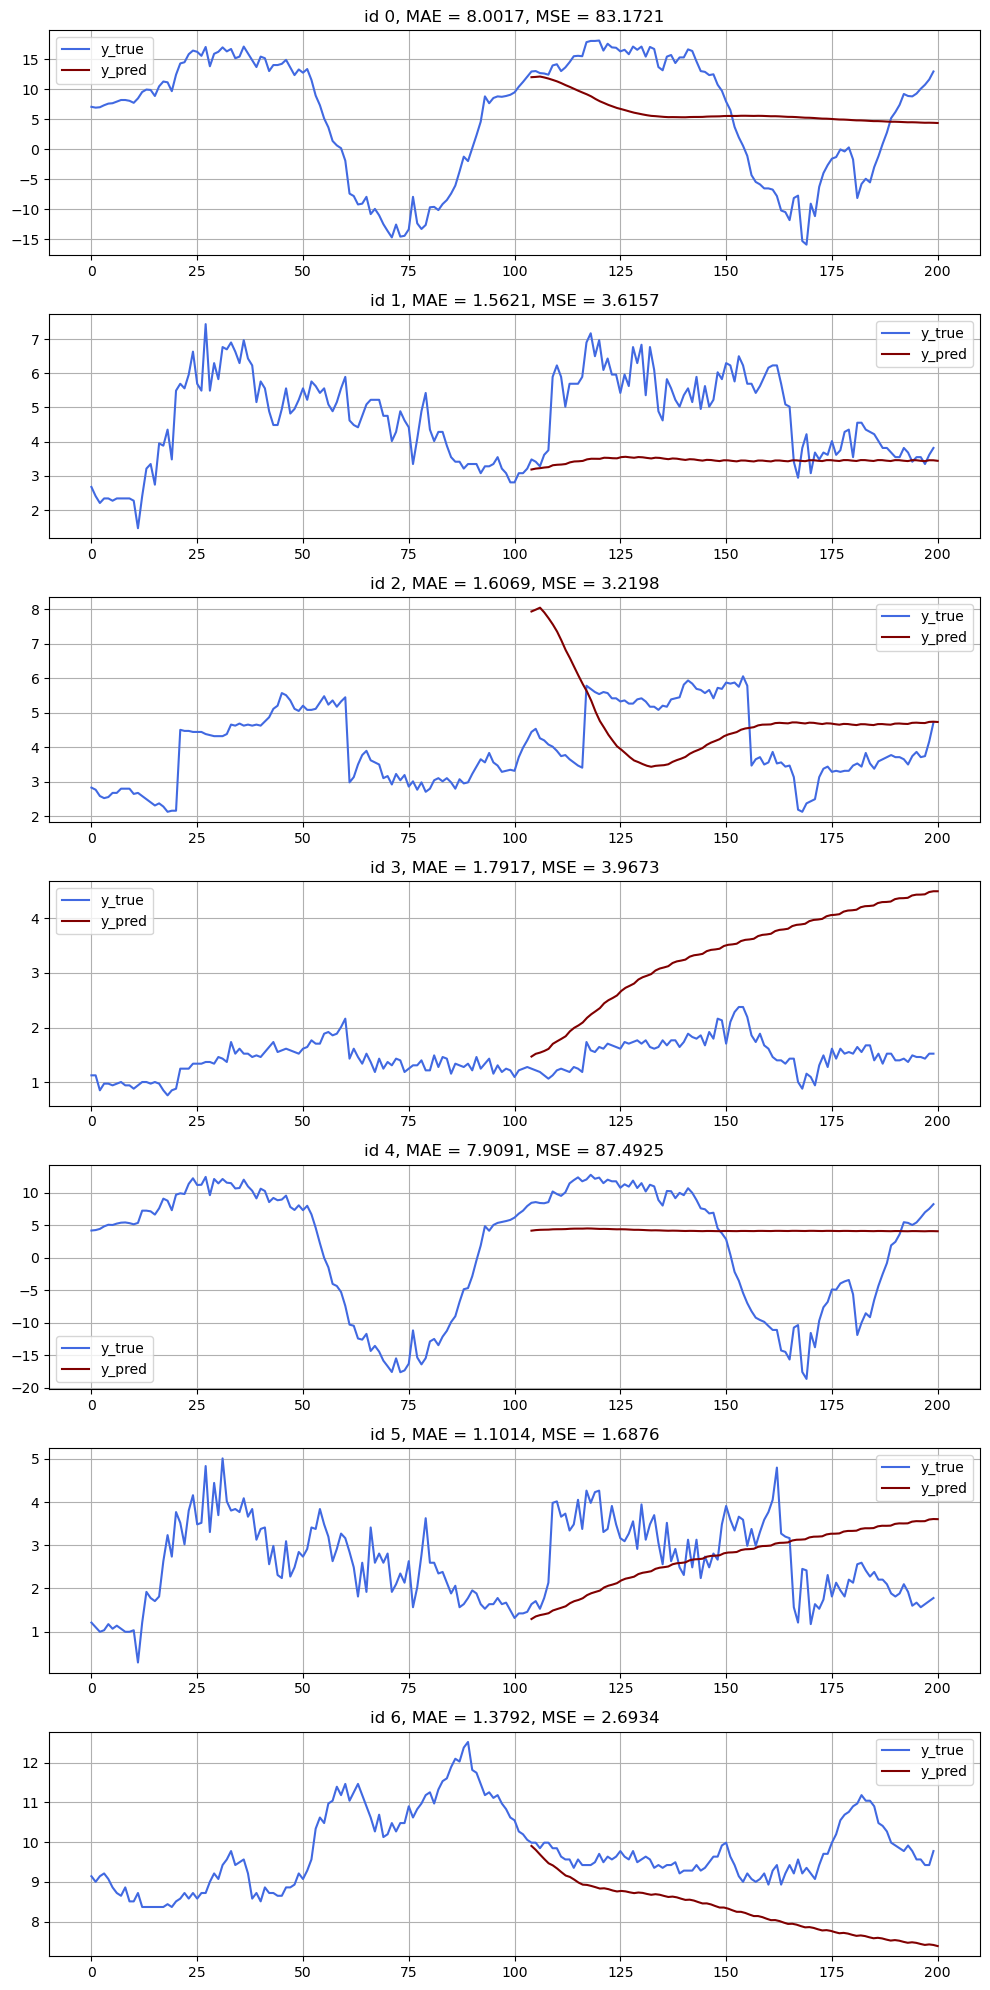

In [21]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_ml_results(df, ridge_preds, axes)

### 4. Random Forest

In [22]:
strategy_params_rf = {
    "is_multivariate": False, 
    # possible values: 
    # [
    #     'RecursiveStrategy', 
    #     'DirectStrategy', 
    #     'DirRecStrategy', 
    #     'MIMOStrategy', 
    #     'FlatWideMIMOStrategy', 
    # ]
    "strategy_name": "RecursiveStrategy",
    "strategy_params": {
        "horizon": 96,
    # possible values: 
    # [
    #     'CatBoostRegressor_CV', 
    #     'LinearRegression_CV', 
    #     'Lasso_CV', 
    #     'Ridge_CV', 
    #     'RandomForest_CV', 
    # ]   
        "model_name": "RandomForest_CV",
        "model_params": model_params_randforest,
        "validation_params": validation_params,
        "k": 1,
    }
}

strategy_rf = strategies_factory[strategy_params_rf]

In [23]:
%%time
ids_rf, test_rf, pred_rf, fit_time_rf, forecast_time_rf, num_iterations_rf = strategy_rf.back_test(dataset, cv=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min


building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.0min


building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  7.3min


building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Fold 0: Score: 0.9839627393172102
building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000building tree 31 of 1000

building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.7min


building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.3min


building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  8.0min


building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    5.7s finished


Fold 1: Score: 0.9839219307593415


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min


building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.2min


building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  7.8min


building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    3.5s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    4.5s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    5.8s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    7.4s finished


Fold 2: Score: 0.9844583097075501
Mean Score: 0.9841
Std: 0.0002


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | ela

CPU times: total: 14h 35min 35s
Wall time: 38min 56s


[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [24]:
rf_preds = get_results(cv=1, regime="global", y_true=test_rf, y_pred=pred_rf, ids=ids_rf)
rf_preds.sample(10)

,y_true_1,y_pred_1,id_1
431,5.848,4.572758,2
538,1.401,1.188,3
96,3.483,3.130598,1
445,3.472,4.600831,2
60,-10.449,11.126285,0
197,10.199,8.442593,4
207,12.153,9.471171,4
201,11.442,8.640861,4
172,3.550,3.107962,1
168,3.617,3.108005,1


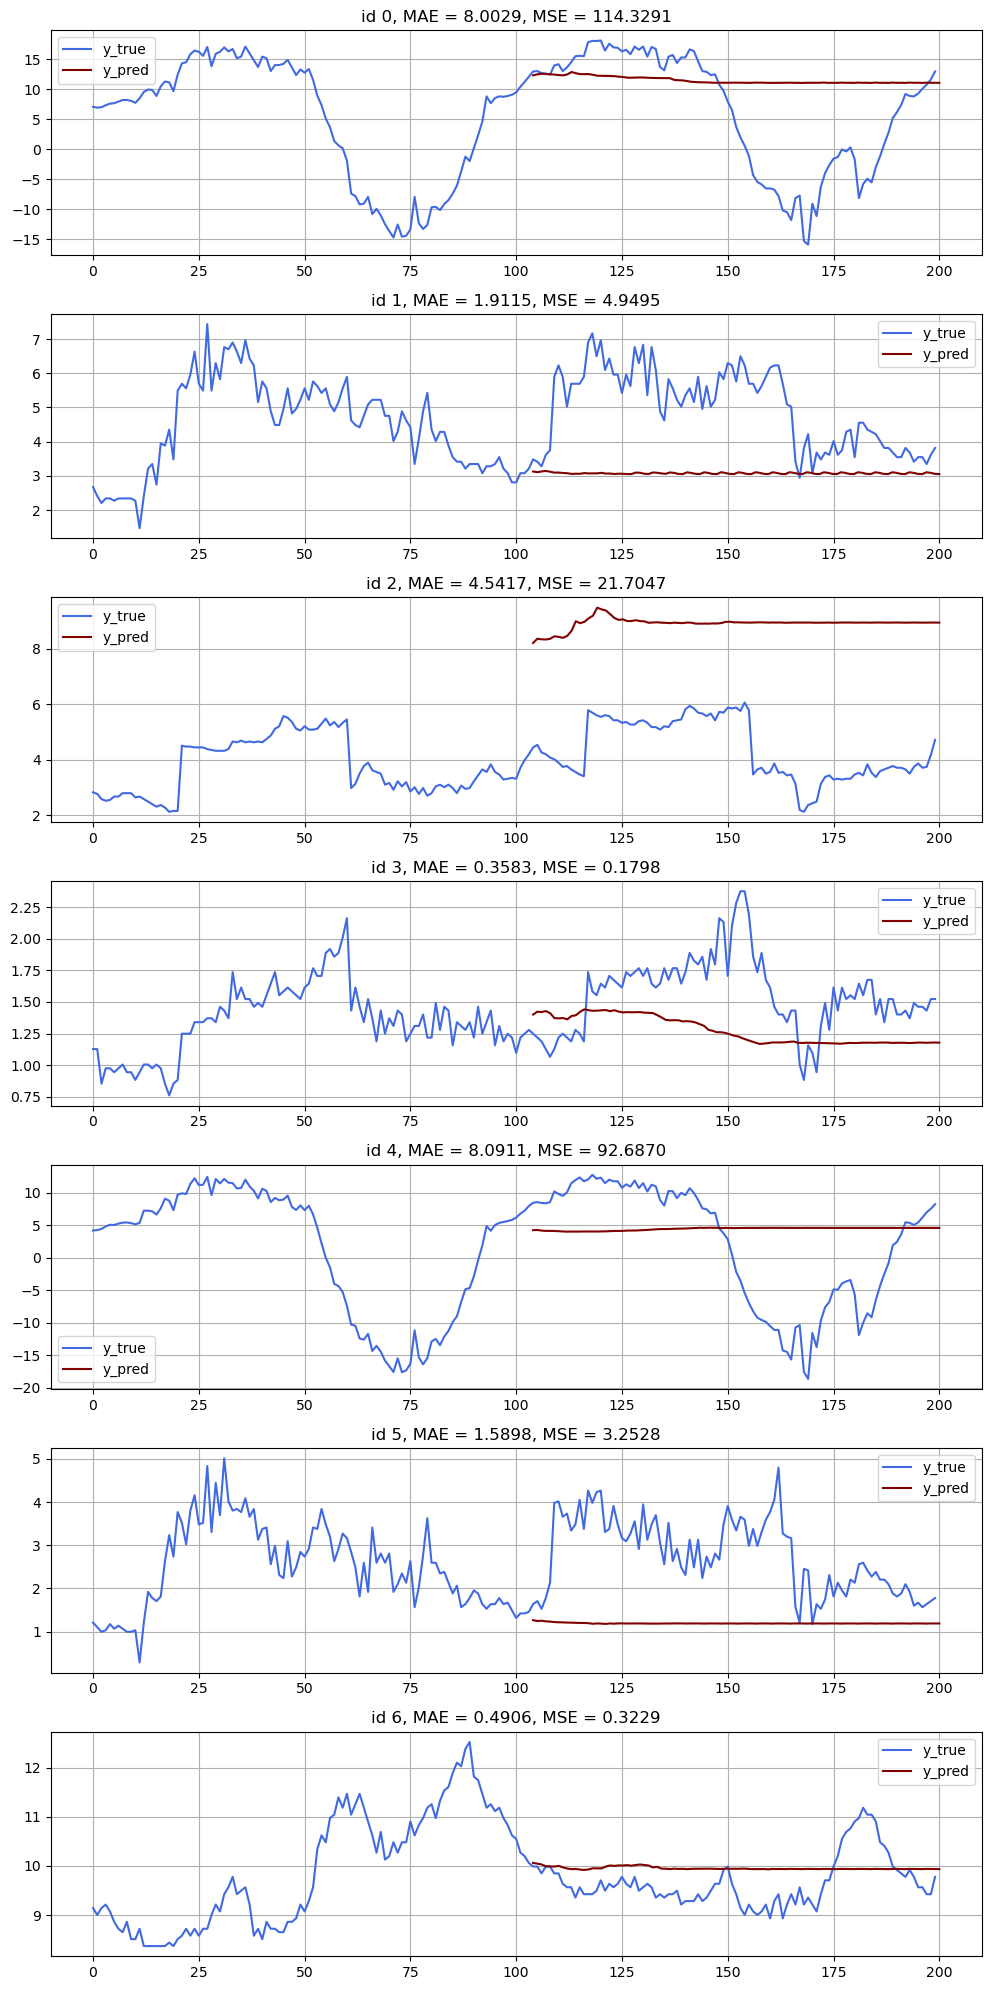

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_ml_results(df, rf_preds, axes)

### 5. Catboost

In [28]:
strategy_params_cat = {
    "is_multivariate": False, 
    # possible values: 
    # [
    #     'RecursiveStrategy', 
    #     'DirectStrategy', 
    #     'DirRecStrategy', 
    #     'MIMOStrategy', 
    #     'FlatWideMIMOStrategy', 
    # ]
    "strategy_name": "RecursiveStrategy",
    "strategy_params": {
        "horizon": 96,
    # possible values: 
    # [
    #     'CatBoostRegressor_CV', 
    #     'LinearRegression_CV', 
    #     'Lasso_CV', 
    #     'Ridge_CV', 
    #     'RandomForest_CV', 
    # ]   
        "model_name": "CatBoostRegressor_CV",
        "model_params": model_params_catboost,
        "validation_params": validation_params,
        "k": 1,
    }
}

strategy_cat = strategies_factory[strategy_params_cat]

In [29]:
%%time
ids_cat, test_cat, pred_cat, fit_time_cat, forecast_time_cat, num_iterations_cat = strategy_cat.back_test(dataset, cv=1)

0:	learn: 4.2265869	test: 4.2450911	best: 4.2450911 (0)	total: 192ms	remaining: 3m 11s
500:	learn: 0.4442411	test: 0.4489200	best: 0.4489200 (500)	total: 7.46s	remaining: 7.43s
999:	learn: 0.4278890	test: 0.4349199	best: 0.4349199 (999)	total: 15s	remaining: 0us

bestTest = 0.4349199486
bestIteration = 999

Fold 0:
MAE: 0.43491994857662725
0:	learn: 4.2316823	test: 4.2340005	best: 4.2340005 (0)	total: 17ms	remaining: 16.9s
500:	learn: 0.4454192	test: 0.4463904	best: 0.4463904 (500)	total: 7.31s	remaining: 7.28s
999:	learn: 0.4291848	test: 0.4329263	best: 0.4329263 (999)	total: 14.8s	remaining: 0us

bestTest = 0.4329262976
bestIteration = 999

Fold 1:
MAE: 0.43292629756454587
0:	learn: 4.2427654	test: 4.2220077	best: 4.2220077 (0)	total: 17.8ms	remaining: 17.7s
500:	learn: 0.4451367	test: 0.4462739	best: 0.4462739 (500)	total: 7.3s	remaining: 7.28s
999:	learn: 0.4296423	test: 0.4328034	best: 0.4328034 (999)	total: 14.9s	remaining: 0us

bestTest = 0.4328033851
bestIteration = 999

Fold 2

In [30]:
cat_preds = get_results(cv=1, regime="global", y_true=test_cat, y_pred=pred_cat, ids=ids_cat)
cat_preds.sample(10)

,y_true_1,y_pred_1,id_1
430,5.879,3.703,2
533,1.736,1.170101,3
315,3.127,1.176547,5
508,1.645,1.175614,3
206,12.757,8.388807,4
263,-4.868,8.631983,4
188,3.550,3.083615,1
3,12.659,12.428145,0
167,4.019,3.086051,1
291,1.777,1.376918,5


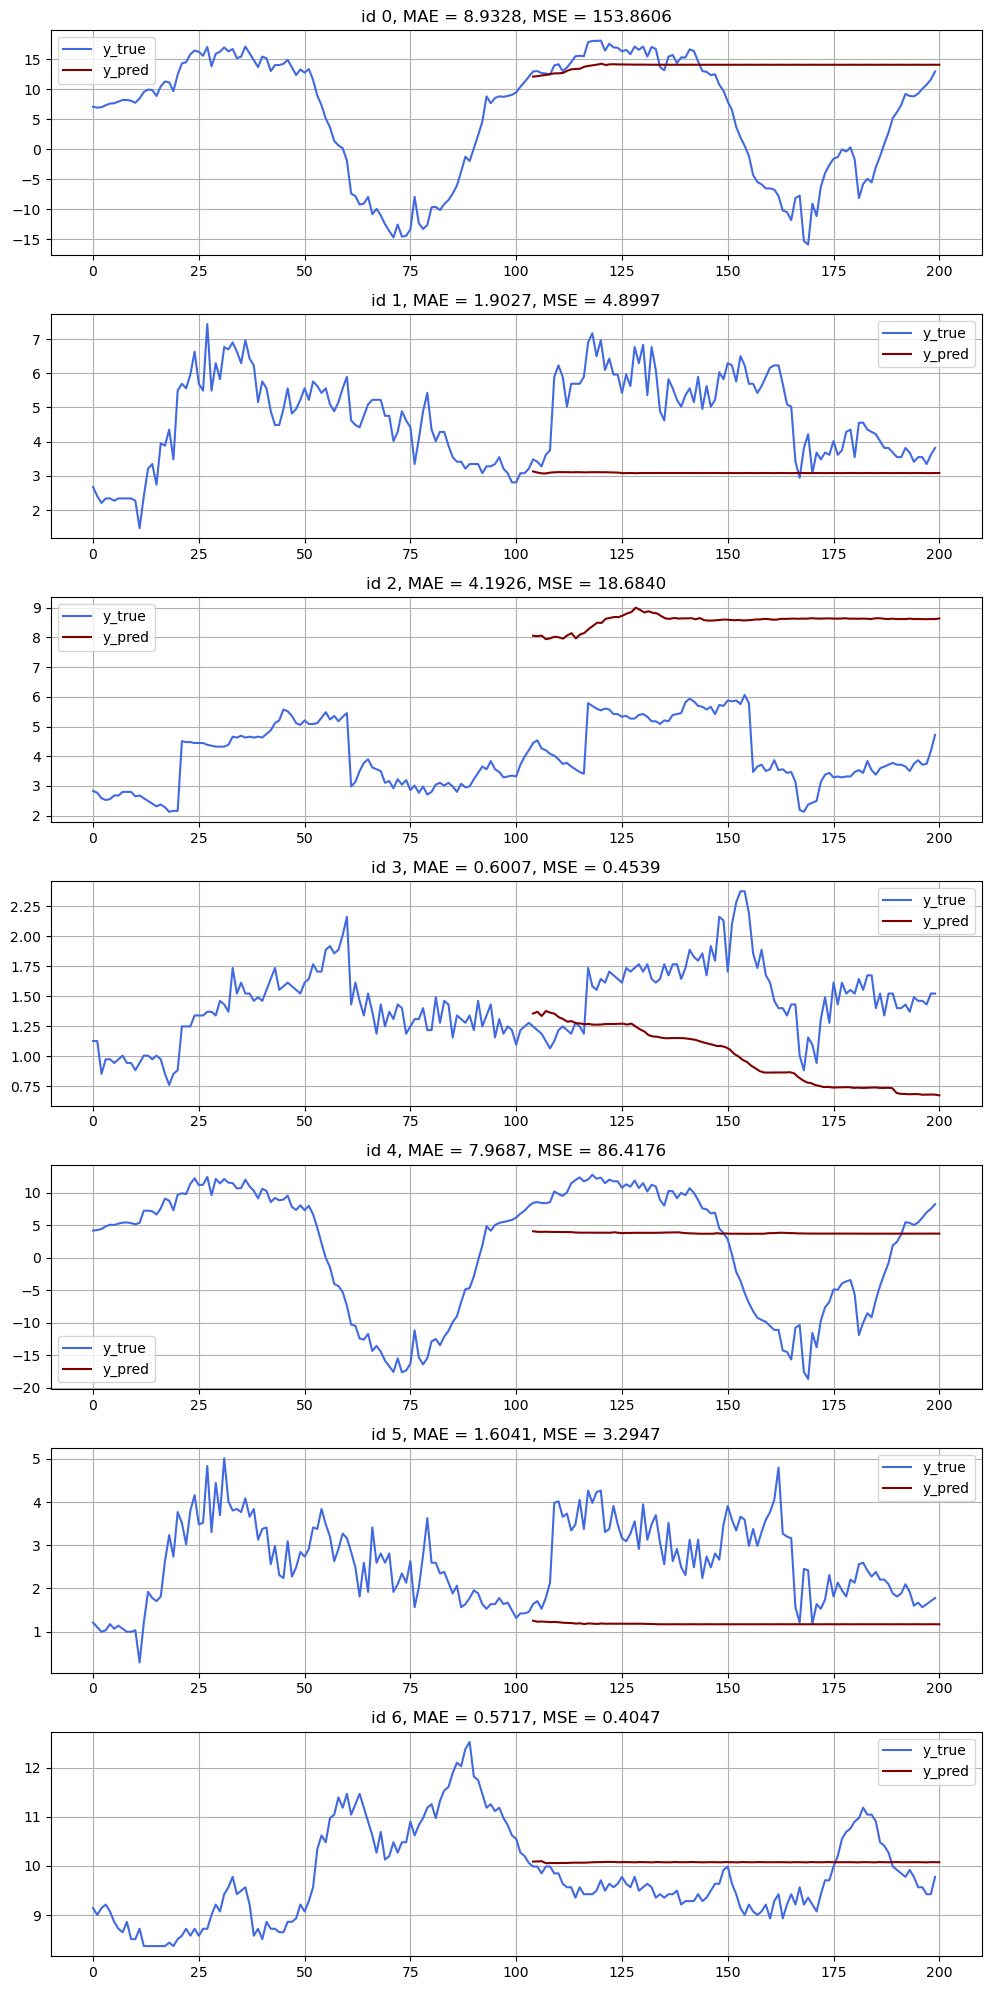

In [31]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_ml_results(df, cat_preds, axes)

In [35]:
cat_preds[cat_preds.id_1==6]

,y_true_1,y_pred_1,id_1
576,9.989,10.08962,6
577,9.989,10.091897,6
578,9.849,10.09707,6
579,9.989,10.056171,6
580,9.989,10.059062,6
...,...,...,...
667,9.567,10.076155,6
668,9.567,10.073359,6
669,9.426,10.077527,6
670,9.426,10.077397,6


---

It is also possible to use the classic fit and predict methods.

In [26]:
#%%time
#fit_time, _ = strategy.fit(dataset)
#forecast_time, current_pred = strategy.predict(dataset)

In [27]:
#current_pred